### Úkol - Výpočet nejkratší (skutečné) vzdálenosti mezi obdélníky

Zadání tohoto úkolu prověřuje vaše pochopení látky probírané na cvičení. Jeho cílem je implementace __výpočtu nejkratší vzdálenosti mezi obdélníky__ na zadaném zdrojovém obrázku. Úkol má první __základní část s nápovědami__ a druhou __dobrovolnou část__ s bonusovými rozšířeními. __Maximální počet bodů za základní část je 5__. Pokud si s něčím nebudete dlouho vědět rady, napište email a domluvíme konzultaci.


Možná se ptáte, k čemu je to vlastně dobré. Motivace je ale jednoduchá - jedná se totiž o celkem běžně řešený problém v praxi. Navíc, v knihovně OpenCV pro to __neexistuje nativní implementace__, takže pokud zůstanete v oboru, může se vám to v budoucnu hodit. Představte si nyní, že vytváříte aplikaci, která má za úkol automatizovaně hrát hru ve které je nutné předcházet kolizím objektů ve scéně. Objekty umíte lokalizovat a ohraničit (nejčastěji obdélníkem), a mohou být různě velké a natočené. Jak nyní zjistit, jak jsou od sebe objekty daleko? V případě, že nebudou objekty (tedy ani obdélníky) natočené, lze vzdálenost vypočíst se znalostí středoškolské geometrie. V reálných situacích se tohle ale moc často nestává. Objekty jsou většinou libovolně natočené a tím se řešení trochu komplikuje. Stále si ale vystačíme se znalostí analytické geometrie ze střední školy, jen bude potřeba trochu programování navíc. Mimo kolize ve hře si můžeme představit využití i např. v aplikaci pro sledování pohybujících se objektů nebo monitorování průmyslových procesů (výrobní linka, spojování materiálů, atd.). 

Abychom si zbytečně nekomplikovali život, budeme řešení implementovat pouze na jednoduchém statickém snímku s několika obdélníky. __Zdrojový snímek základní verze je__ [patterns_photo_basic.jpg](patterns_photo_basic.jpg). Využijeme naší znalost ze cvičení a budou nás __zajímat nejkratší vzdálenosti v centimetrech__, nikoliv v pixelech.

Předpokladem tohoto úkolu je, že __máte vypracovaný notebook z 3. cvičení__. Budeme totiž znovu potřebovat segmentované kontury všech objektů, a vzhledem k tomu, že už máme nějakou práci hotovou, byla by škoda na ni nenavázat. Využijeme tedy vypracovaný notebook ze cvičení, upravíme pouze barevné intervaly ve funkcích `inRange()` tak, aby dávaly smysl pro nový zdrojový obrázek. 

### Import knihoven a konfigurace

In [1]:
import argparse
import os
import shutil
import re
import math

import numpy as np
import matplotlib.pyplot as plt
import cv2
import yaml

from IPython.display import Image, display

from scipy.spatial import distance
from natsort import natsorted

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

### Pomocné funkce


In [2]:
%run ../svz.ipynb

### Úkol 1

Úkol je zaměřen na segmentace obrazů, získání kontur objektů a měření poměru rozměrů v cm a pixelech.

**1) Načtěte a zkontrolujte zaznamenaný obrázek vzoru pomocí kamery. Nadefinujte proměné s šířkou a výškou referečního objektu.**

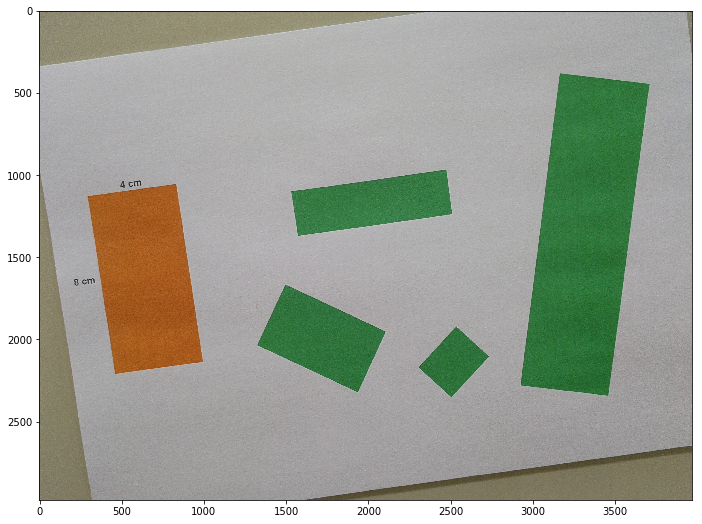

In [3]:
img_patterns = cv2.imread('./patterns_photo_basic.jpg')
plot_images(img_patterns)

In [4]:
ref_width_real = 4
ref_height_real = 8

**2) Využijte funkci [cv2.inRange()](https://docs.opencv.org/3.4.1/d2/de8/group__core__array.html#ga48af0ab51e36436c5d04340e036ce981) k získání masky referenčního obdélníku.**

Funkce kromě zdrojového obrázku přijímá dolní a horní mez hodnoty pixelů ve formátu BGR (pozor celé OpenCV funguje v režimu BGR, ne RGB). Tedy dvě trojice (tuple) ve formátu (b, g, r), kde 0 <= b, g, r <= 255. Pixely s hodnotou >= než dolní mez a <= než horní mez budou mít ve výsledné masce hodnotu 255, ostatní 0. 

Dolní a horní mez naleznete experimentálně.

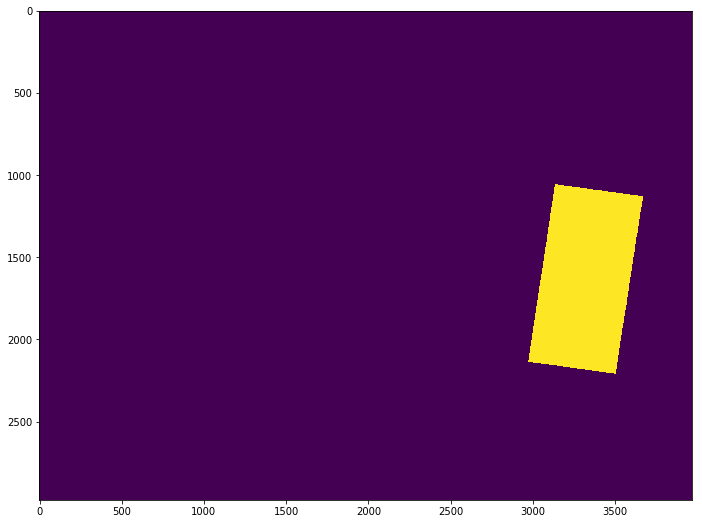

In [5]:
lower_bound = (0, 0, 110)
upper_bound = (70, 255, 255)
ref_mask = cv2.inRange(img_patterns, lower_bound, upper_bound) ###
plot_images(ref_mask)

**3) Naleznete konturu která pokrývá nevětší plochu, otestujte aproximace kontury na obdélník.**

Výsledná maska by měla ideálně obsahovat pouze referenční obdelník, v obrazu se ale obecně může vyskytovat i šum. 
Nyní je nutné získat pozici referenčního obdelníku v obraze masky. 
Nejjednoduším způsobem je vyhledání kontur (obrysů) v obraze pomocí [cv2.findContours()](https://docs.opencv.org/3.3.1/d3/dc0/group__imgproc__shape.html#ga17ed9f5d79ae97bd4c7cf18403e1689a). Vyhledání kontur funguje jen na binárním černobílém obraze, proto jsme nejdříve museli využít cv2.inRange() k získání masky.

Konturu si lze představit jako křivku spojující několik bodů kolem obrysu souvislého objektu. Funkce cv2.findContours() příjímá navíc dva parametry, contour retrieval mode a contour approximation method. Těmito parametry se ve většině případů nemusíme zabývat. Zjednodušeně je tedy nastavíme `mode=cv2.RETR_LIST` a `method=cv2.CHAIN_APPROX_SIMPLE`. Pokud by vás přeci jen zajímaly, můžete si o nich přečíst [zde](https://docs.opencv.org/3.3.1/d4/d73/tutorial_py_contours_begin.html)

Vzhledem k šumu, který se na každém snímku vyskytuje, prakticky nikdy nenajdeme konturu pouze jednu. Je tedy nutné následně provést filtrování. V našem případě si vystačíme s výběrem kontury, která má největší plochu.

Posledním krokem je validace našeho postupu a vizualizace nalezené kontury pomocí funkce [cv2.drawContours()](https://docs.opencv.org/3.3.1/d6/d6e/group__imgproc__draw.html#ga746c0625f1781f1ffc9056259103edbc).
                                                                                

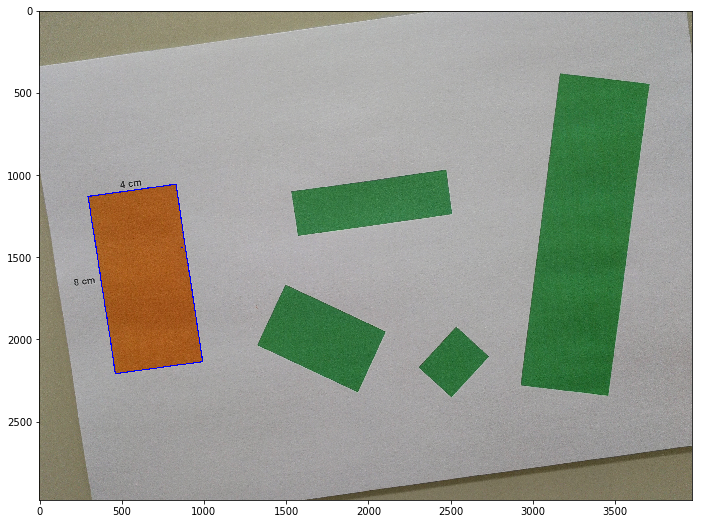

In [6]:
_, contours, _  = cv2.findContours(ref_mask, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE) ###
#print(f'Found {len(contours)} contours.')
# pick only the contour with the biggest area
contour_biggest = max(contours, key=cv2.contourArea)
#print(f'Biggest contour area: {cv2.contourArea(contour_biggest)}, coordinates:\n {contour_biggest.reshape((-1, 2)).tolist()}')
contour_drawn = cv2.drawContours(img_patterns.copy(), contours, -1, color=(255, 0, 0), thickness=5)
plot_images(contour_drawn)

Z výsledných souřadnic vidíme, že kontura netvoří přesný obdelník, proto ji musíme obdelníkem aproximovat. To lze pomocí funkce [cv2.minAreaRect](https://docs.opencv.org/3.1.0/d3/dc0/group__imgproc__shape.html#ga3d476a3417130ae5154aea421ca7ead9). Návratovou hodnotou této funkce je tuple - (střed obdélníku (x,y), (výška, šířka), úhel rotace obdélníku). Jedna otázka zní, co je výška a co je šířka? Musíte to vždycky kontrolovat okem.

Pomocná funkce [cv2.boxPoints()](https://docs.opencv.org/3.1.0/d3/dc0/group__imgproc__shape.html#gaf78d467e024b4d7936cf9397185d2f5c) převádí nalezený obdelník z formátu (střed obdélníku (x,y), (šířka, výška), úhel rotace obdélníku) na 4 rohové body obdélníku ve formátu (x, y). To se může hodit např. k vizualizaci (lze použít jako vstup pro cv2.drawContours()). Pozor, pořadí vrácených bodů není zaručeno.

In [7]:
rect = cv2.minAreaRect(contour_biggest) ###
# rect = cv2.fitEllipse(contour_biggest) ###
print(f'Rect tuple: {rect}')
print(f'(cx, cy)={rect[0]}, (width, height)={rect[1]}, angle={rect[2]}')
print(f'Rect points: {cv2.boxPoints(rect).tolist()}')

Rect tuple: ((645.6346435546875, 1633.422607421875), (542.30322265625, 1098.1705322265625), -8.586421966552734)
(cx, cy)=(645.6346435546875, 1633.422607421875), (width, height)=(542.30322265625, 1098.1705322265625), angle=-8.586421966552734
Rect points: [[459.50115966796875, 2216.836669921875], [295.54315185546875, 1130.974853515625], [831.7681274414062, 1050.008544921875], [995.7261352539062, 2135.870361328125]]


**5) Nalezenou šířku referenčního obdelníku v pixelech můžeme konečně využít k získání poměru skutečné šířky obdélníku v reálných jednotkách a pixelové šířky obdélníku v obraze. Tento poměr budeme následně potřebovat k výpočtu rozměrů ostatních neznámých objektů.**

In [8]:
ref_width_image, ref_height_image = rect[1]
real_image_ratio_width = ref_width_image / ref_width_real 
print(f'Ratio between image width and real width: {real_image_ratio_width}')
real_image_ratio_height = ref_height_image / ref_height_real 
print(f'Ratio between image height and real height: {real_image_ratio_height}')

# they are a bit different, so I guess the average might work the best
real_image_ratio = (real_image_ratio_height+real_image_ratio_width)/2
print(f'Ratio between image and real : {real_image_ratio}')

Ratio between image width and real width: 135.5758056640625
Ratio between image height and real height: 137.2713165283203
Ratio between image and real : 136.4235610961914


### Úkol 2

Úkol 1 máme za sebou a už víme poměr mezi rozměrem v cm a pixelech, tím pádem už můžeme naměřit rozměry ostatních objektů na obrázku s neznámými rozměry.

**1) Opět využijte funkci [cv2.inRange()](https://docs.opencv.org/3.4.1/d2/de8/group__core__array.html#ga48af0ab51e36436c5d04340e036ce981), tentokrát k získání masky objektů s neznámými skutečnými rozměry.**

**2) Nalezněte v nové masce snímku kontury stejně jako v případě referenčního objektu.**

**3) Následně je provedeno filtrování kontur podle jejich obsahu. Prahovou hodnotu obsahu v pixelech (threshold) je nutno zvolit experimentálně.**

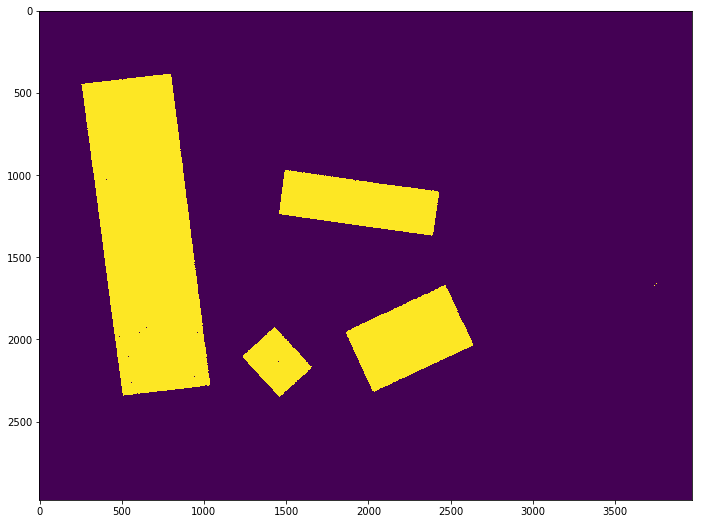

In [9]:
lower_bound_p = (0, 90, 15)
upper_bound_p = (255, 255, 90)
patterns_mask = cv2.inRange(img_patterns, lower_bound_p, upper_bound_p)
plot_images(patterns_mask)

Found 1146 contours.
After filtering, 4 contours remained.


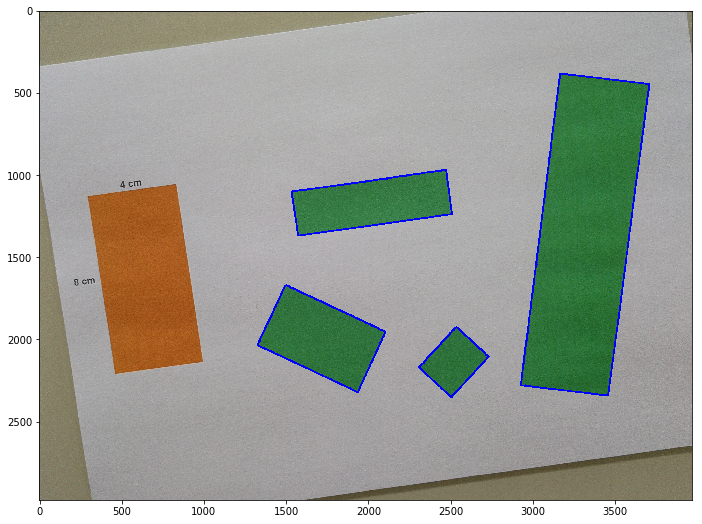

In [10]:
_, contours, _  = cv2.findContours(patterns_mask, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE) ###
print(f'Found {len(contours)} contours.')

# Filter out noise
threshold = 50 ###
contours =  [c for c in contours if cv2.contourArea(c) > threshold]
print(f'After filtering, {len(contours)} contours remained.')

contour_drawn = cv2.drawContours(img_patterns.copy(), contours, -1, color=(255, 0, 0 ), thickness=10)
plot_images(contour_drawn)

# Sort contours by area. Just for better debugging.
contours.sort(key=cv2.contourArea, reverse=True)

**4) Nalezněte skutečné rozměry objektu**

Nyní potřebujeme pro jednotlivé kontury zjistit jejich skutečné rozměry, které chceme vizualizovat do výsledného obrázku.

Pro každou konturu tedy získáme jeji obdélníkovou aproximaci pomocí [cv2.minAreaRect](https://docs.opencv.org/3.1.0/d3/dc0/group__imgproc__shape.html#ga3d476a3417130ae5154aea421ca7ead9). Následně můžeme vypočítat skutečnou šířku a výšku objektu, díky předešlému vypočítanému poměru mezi skutečnou šířkou a pixelovou šířkou. Posledním krokem je volání funkce `draw_real_sizes()`, která se do vstupního obrázku pokusí vykreslit rozměry nalezeného objektu.

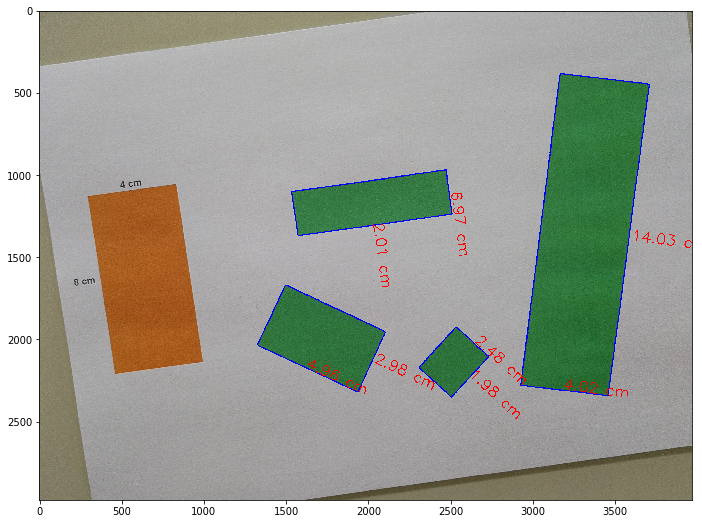

In [11]:
sizes_drawn = img_patterns.copy()

for c in contours:
    # rect = cv2.fitEllipse(c) ###
    rect = cv2.minAreaRect(c)
    shape_width, shape_height = rect[1] ### 
    real_width = shape_height/real_image_ratio  ###
    real_height = shape_width/real_image_ratio ###
    
    cv2.drawContours(sizes_drawn, [c], -1, color=(255, 0, 0 ), thickness=5)
    sizes_drawn = draw_real_sizes(sizes_drawn, rect, real_width, real_height, 
                                  lbl_size_scale=3, lbl_color=(0, 0, 255), lbl_thickness=4) ###

# show_images(sizes_drawn)
plot_images(sizes_drawn)

### Základní část

In [12]:
import itertools
import math
import cv2

V řešení ze cvičení už máme hotové segmentace referenčního i ostatních objektů uložené formou kontur. 
Všechny tyto kontury se vyplatí přemístit do jedné struktury, neboť se s ní následně bude lépe pracovat.

__1) Přesuňte všechny kontury do jedné struktury (např. list).__

In [13]:
# contour_biggest = the orange rectangle, contours = the green rectangles
contours_list = [contour_biggest] + contours

__2) Pomocí funkce `len()` ověřte, že jich máte správný počet.__

In [14]:
print(len(contours_list))

5


__3) Uložte si hodnoty všech možných indexů předchozího listu do nového listu. Může se vám k tomu hodit funkce `range()` + `list()`. Ideálně využijte i předchozí informaci o počtu kontur.__

In [15]:
# get the indexes into a list using list comprehension
indexes = [i for i in range(len(contours_list))]
print(indexes)

[0, 1, 2, 3, 4]


__4) Využijte funkci `itertools.combinations()` k získání všech možných dvojic kombinací indexů kontur. Pro jistotu si je vypiště.__

In [16]:
index_combinations = list(itertools.combinations(indexes, 2))
print(index_combinations)

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


Nyní už to konečně začne být trochu zajímavé. Zbývá __projít všechny možné kombinace kontur, aproximovat je obdélníkem
vypočítat vzdálenost mezi všemi obdélníky, a výsledek vhodně vizualizovat v reálných jednotkách__. 
To je na jednu Jupyter buňku až moc operací, lepší řešení tedy bude tyto kroky rozpadnout do několika funkcí.

Pro zjedodnušení celé úlohy __není nutné uvažovat žádné složité speciální případy__ - nejsme Progtest. Nemusíte tedy uvažovat, že se tvary jakkoliv překrývají. Předpokládáme, že vzdálenost je vždy > 0. S tím také souvisí pozdější detaily jako __neřešení případů bodu ležícího na úsečce, úsečky se protínají, atd__.

__5) Doplňte funkci pro výpočet vzdálenosti mezi úsečkou a bodem.__

In [17]:
# used source: http://paulbourke.net/geometry/pointlineplane/
def line_segment_to_point_dist(l_pt1, l_pt2, dst_pt):
    # function to calculate Euclidean distance
    def euclid_dist(l_pt1, l_pt2):
        return math.sqrt(math.pow(l_pt1[0] - l_pt2[0], 2) + math.pow(l_pt1[1] - l_pt2[1], 2))
    
    line_len = euclid_dist(l_pt1, l_pt2)
    if (line_len == 0): # the line segment is just a point
        return euclid_dist(l_pt1, dst_pt)
    
    t = ((dst_pt[0]-l_pt1[0])*(l_pt2[0]-l_pt1[0])+(dst_pt[1]-l_pt1[1])*(l_pt2[1]-l_pt1[1]))/pow(line_len, 2) 
    
    # line segment => we have to check whether the t is between 0 and 1
    if (t < 0): # point lies "outside of the line seg.", on the side that is closer to the first line point
        return euclid_dist(l_pt1, dst_pt)
    if (t > 1): # point lies "outside of the line seg.", on the side that is closer to the second line point
        return euclid_dist(l_pt2, dst_pt)
    # else: we can draw a normal which passes through the point
    return euclid_dist(dst_pt, (l_pt1[0]+t*(l_pt2[0]-l_pt1[0]), l_pt1[1]+t*(l_pt2[1]-l_pt1[1])))

__6) Otestujte, že funkce vrací správné výsledky.__

In [18]:
assert line_segment_to_point_dist((1,3), (3,4), (4,4)) ==  1

assert line_segment_to_point_dist((1,3), (3,4), (0,3)) ==  1
assert line_segment_to_point_dist((2,2), (4,4), (4,2)) ==  math.sqrt(2)
assert line_segment_to_point_dist((2,2), (4,4), (6,2)) ==  2*math.sqrt(2)
assert line_segment_to_point_dist((2,2), (10,10), (10,0)) ==  5*math.sqrt(2)
assert line_segment_to_point_dist((2,2), (10,10), (5,5)) ==  0
assert line_segment_to_point_dist((2,2), (10,10), (11,11)) ==  math.sqrt(2)

Nyní potřebujeme další stavební blok, a to nejkratší vzdálenost dvou úseček. K tomu využijeme už hotovou funkci `line_segment_to_point_dist()`. Pokud vás nenapadá jak, zkuste si to nakreslit na papír.
Nezapomeňte, že __nemusíme uvažovat speciální případy__ (např. to, že se protínají). S využítím funkce `min()` je to dokonce pouze na jeden řádek kódu.

__7) Doplňte funkci pro výpočet vzdálenosti mezi dvěmi úsečkami.__

In [19]:
def line_segments_dist(l1_pt1, l1_pt2, l2_pt1, l2_pt2):
    return min(line_segment_to_point_dist(l1_pt1, l1_pt2, l2_pt1), line_segment_to_point_dist(l1_pt1, l1_pt2, l2_pt2),
               line_segment_to_point_dist(l2_pt1, l2_pt2, l1_pt1), line_segment_to_point_dist(l2_pt1, l2_pt2, l1_pt2))    

__8) Otestujte, že funkce vrací správné výsledky.__

In [20]:
assert line_segments_dist((1,3), (3,4), (5,7), (5,1)) ==  2
assert line_segments_dist((1,5),(6,5), (7,7), (7,5)) == 1

assert line_segments_dist((1,1),(3,3), (3,1), (4,2)) == math.sqrt(2)
assert line_segments_dist((5,2),(5,1), (3,2), (4,3)) == math.sqrt(2)
assert line_segments_dist((0,0),(1,2), (2,2), (3,0)) == 1
assert line_segments_dist((1,0),(0,2), (10,2), (3,0)) == 2
assert line_segments_dist((1,1),(2,2), (3,3), (4,4)) == math.sqrt(2)
assert line_segments_dist((1,1),(2,2), (3,3), (2,2)) == 0

__9) Doplňte funkci pro výpočet vzdálenosti mezi dvěma obdélníky.__

In [21]:
def rect_dist(r1_pts, r2_pts):
    # get the rectangle's lines from corner points
    def get_lines(r_pts):
        tl, tr, br, bl = order_points(np.array(r_pts))
        return [(tl, tr), (tl, bl), (tr, br), (bl, br)]
    
    r1_lines = get_lines(r1_pts)
    r2_lines = get_lines(r2_pts)
    
    # find the min distance between lines from the rectangles
    dist_min = float("inf")
    for r1_line in r1_lines:
        for r2_line in r2_lines:
            dist_min = min(dist_min, line_segments_dist(*r1_line, *r2_line))
            
    return dist_min

__10) Otestujte, že funkce vrací správné výsledky.__

In [22]:
assert rect_dist(((1,5), (6,5), (6,3), (1,3)), ((7,7), (9,7), (9, 5), (7, 5))) == 1
assert rect_dist(((1,5), (6,5), (6,3), (1,3)), ((4,10), (6, 8), (4, 6), (2,8))) == 1

assert rect_dist(((1,1), (2,2), (2,1), (1,2)), ((1,11), (1, 10), (2, 10), (2,11))) == 8
assert rect_dist(((1,7), (2,8), (2,6), (3,7)), ((3,7), (4, 8), (4, 6), (5,7))) == 0
assert rect_dist(((2,4), (3,5), (3,3), (4,4)), ((4,7), (3, 6), (5, 4), (6,5))) == math.sqrt(2)/2
assert rect_dist(((1,1), (2,2), (2,1), (1,2)), ((3,3), (4, 3), (3, 4), (4,4))) == math.sqrt(2)
assert rect_dist(((0,0), (0,1), (1,0), (1,1)), ((11,11), (12, 11), (11, 12), (12,12))) == 10*math.sqrt(2)

Blížíme se do finále. Úplně v první buňce tohoto úkolu bychom měli mít vytvořený list se všemi konturami a list všech dvojic kombinací indexů kontur. Kontury vhodně převeďte tak, aby je bylo možné předat do definované funkce `rect_dist()` a tím získat vzdálenost mezi dvěma obdélníky v pixelech. Následně přepočítejte pixely na skutečné jednotky a vypiště nalezené vzdálenosti ve vhodném a kontrolovatelném formátu (např.: 1 <-> 3: 2.2 cm). 

__11) Vypočítejte vzdálenosti mezi všemi obdélníky ve snímku, vypiště vzdálenosti ve vhodném formátu v centimetrech.__

In [23]:
# use minAreaRect on each contour to approximate them with a rectangle
rectangles = []
for c in contours_list:
    rect = cv2.minAreaRect(c)
    rectangles.append(rect)

for comb in index_combinations:
    # get corner points of both rectangles
    r1_pts = cv2.boxPoints(rectangles[comb[0]])
    r2_pts = cv2.boxPoints(rectangles[comb[1]])
    
    dist = rect_dist(r1_pts, r2_pts)
    real_dist = dist / real_image_ratio
    
    print("{} <-> {} = {}".format(comb[0], comb[1], real_dist))

0 <-> 1 = 14.171195347903174
0 <-> 2 = 2.4938640100654874
0 <-> 3 = 5.006288707376304
0 <-> 4 = 9.608772685795612
1 <-> 2 = 6.221025314473532
1 <-> 3 = 3.950526209538609
1 <-> 4 = 1.5408972441929953
2 <-> 3 = 2.220439304290079
2 <-> 4 = 1.9779014957605012
3 <-> 4 = 4.966668764901309
